In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [8]:
import sys
sys.path.append("../dnn_from_scratch")
sys.path.append("../dnn_scratch_basic_implementations")

In [9]:
import cifar_pre_process
dt = cifar_pre_process.CifarPreProcess()
dt.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [4]:
X_train=np.concatenate([dt.training_images,dt.test_images]).reshape(-1,32,32,3)*2-1

In [10]:
from nnet_gpu.network import Sequential
from nnet_gpu.layers import Conv2D,MaxPool,Flatten,Dense,Dropout,Conv2Dtranspose,Upsampling,Reshape,BatchNormalization,Activation
from nnet_gpu import functions
from nnet_gpu import optimizers
import numpy as np
import cupy as cp

In [11]:
def generator():
    model=Sequential()
    model.add(Dense(128*8*8,activation=functions.leakyRelu,input_shape=100))
    model.add(Reshape((8,8,128)))
#     model.add(Upsampling())
#     model.add(Conv2D(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(Conv2Dtranspose(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(Upsampling())
#     model.add(Conv2D(32,kernel_size=3,activation=functions.leakyRelu))
    model.add(Conv2Dtranspose(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(Conv2D(3,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- InputLayer(InputLayer)  (None, 100)                echo             0
__________________________________________________________________________________________
0 Dense(Dense)            (None, 8192)               leakyRelu        827392
__________________________________________________________________________________________
1 Reshape(Reshape)        (None, 8, 8, 128)          echo             0
__________________________________________________________________________________________
2 Conv2Dtranspose(Conv2Dt (None, 16, 16, 64)         leakyRelu        73792
__________________________________________________________________________________________
3 BatchNormalization(Batc (None, 16, 16, 64)         echo             256
__________________________________________________________________________________________
4 Con

In [12]:
def discriminator():
    model=Sequential()
    model.add(Conv2D(32,kernel_size=3,activation=functions.leakyRelu,input_shape=(32,32,3)))
    model.add(MaxPool())
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(MaxPool())
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256,activation=functions.leakyRelu))
    model.add(Dropout(0.25))
    model.add(Dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- InputLayer(InputLayer)  (None, 32, 32, 3)          echo             0
__________________________________________________________________________________________
0 Conv2D(Conv2D)          (None, 32, 32, 32)         leakyRelu        896
__________________________________________________________________________________________
1 MaxPool(MaxPool)        (None, 16, 16, 32)         echo             0
__________________________________________________________________________________________
2 BatchNormalization(Batc (None, 16, 16, 32)         echo             128
__________________________________________________________________________________________
3 Dropout(Dropout)        (None, 16, 16, 32)         echo             0
__________________________________________________________________________________________
4 Conv2D(Con

In [8]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [9]:
def gen_sample():
    noise=np.random.randn(64,100).astype(np.float32)
    gen=g.predict(noise)
    noise=np.random.randn(1,100).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow((gen[0]+1)/2,interpolation='bicubic')
    plt.show()
    print(d.predict(gen)[0])

In [10]:
def run():
    batch_size=64
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
#         X = np.concatenate([real_images,generated_images])
        # Train discriminator
        y_real=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
        y_fake=np.random.uniform(0,0.1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
        noise=np.random.randn(batch_size*2,100).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%50:
            gen_sample()
        print("\rProgress: {:.2f} %     Dloss: {}    err: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,abs(err).mean(),time()-stt),end='')

EPOCH: 1 / 2


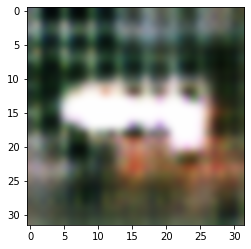

[0.11114409]
Progress: 5.23 %     Dloss: 33.032318115234375    err: 0.00909945834428072     Sample time: 1.096s    __

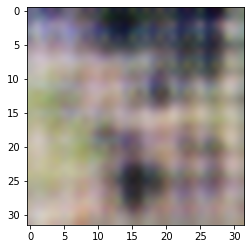

[0.1557891]
Progress: 10.56 %     Dloss: 43.64887237548828    err: 0.012723586522042751     Sample time: 1.065s    __

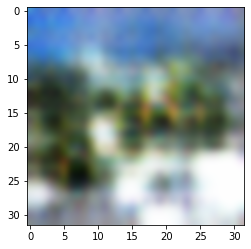

[0.34140506]
Progress: 13.87 %     Dloss: 33.62274932861328    err: 0.012318160384893417     Sample time: 1.121s    __

KeyboardInterrupt: 

In [23]:
epochs=2
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    gen_sample()

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

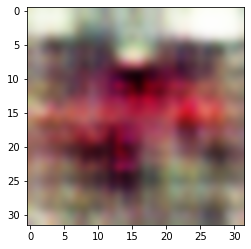

[0.55314016]


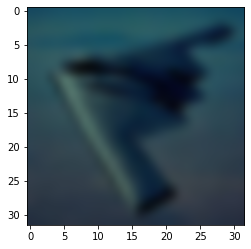

[[0.88512963]]


In [33]:
noise=np.random.randn(64,100).astype(np.float32)
gen=g.predict(noise)
gen_sample()
img=X_train[np.random.randint(low=0,high=X_train.shape[0],size=1)]
plt.imshow((img[0]+1)/2,interpolation='bicubic')
plt.show()
print(d.predict(img))

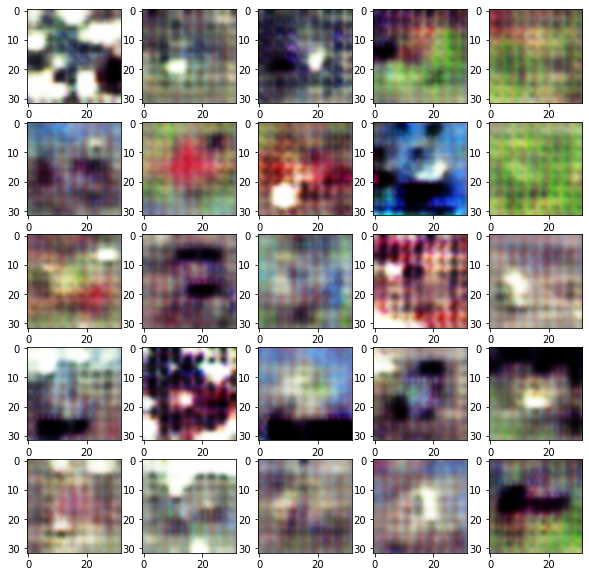

In [37]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
noise=np.random.randn(25,100).astype(np.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.imshow((gen[i].squeeze()+1)/2,interpolation='bicubic')